# FreeCAD + Sympy-Mechanics -> Rotating Box

## Imports

In [21]:
from __future__ import division

import FreeCAD as App

import numpy as np
np.set_printoptions(precision=3)

import sympy
from sympy.physics import mechanics
sympy.init_printing()

from pydy.codegen.ode_function_generators import generate_ode_function

from scipy.integrate import odeint

from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (20.0, 6.0)
%matplotlib inline

from PySide import QtCore
import time

## Helpers

In [22]:
def mat_to_np(mat):
    elements = mat.A
    return np.array([[elements[j * 4 + i] for i in range(4)] for j in range(4)])

def np_to_mat(np_mat):
    App.Matrix(*np_mat.flatten())

def vec_to_np(vec):
    return np.array(list(vec))

## CAD input

In [23]:
rho = 7800 / 1000 ** 3
document = App.getDocument("RotationBox1")
box = document.Box
inert = mat_to_np(box.Shape.MatrixOfInertia) * rho
mass = box.Shape.Volume * rho
cog = vec_to_np(box.Shape.CenterOfMass)
cog

array([ 5. ,  5. ,  0.5])

## Kinematic

### Reference Frames

In [24]:
I = mechanics.ReferenceFrame("I")
R1 = mechanics.ReferenceFrame("R1")
R2 = mechanics.ReferenceFrame("R2")
B = mechanics.ReferenceFrame("B")

In [25]:
theta_x, theta_y, theta_z = mechanics.dynamicsymbols("theta_x theta_y theta_z")
theta = [theta_x, theta_y, theta_z]
omega_x, omega_y, omega_z = mechanics.dynamicsymbols("omega_x omega_y omega_z")
omega = [omega_x, omega_y, omega_z]
R1.orient(I, "Axis", (theta_z, I.z))
R2.orient(R1, "Axis", (theta_y, R1.y))
B.orient(R2, "Axis", (theta_x, R2.x))

In [26]:
R1.set_ang_vel(I, omega_z * I.z)
R2.set_ang_vel(R1, omega_y * R1.y)
B.set_ang_vel(R2, omega_x * R2.x)

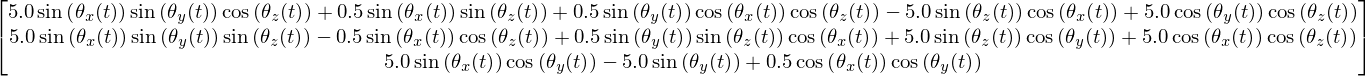

In [27]:
O = mechanics.Point("O")
box_cog = mechanics.Point("P")
O.set_vel(I, 0)
box_cog.set_pos(O, cog[0] * B.x + cog[1] * B.y + cog[2] * B.z)
box_cog.v2pt_theory(O, I, B)
sympy.simplify(box_cog.pos_from(O).to_matrix(I))

## Inertia

In [28]:
inertia = mechanics.inertia(B, inert[0, 0], inert[1, 1], inert[2, 2])
box_body = mechanics.RigidBody("box", box_cog, B, mass, (inertia, box_cog))

## Loads

In [29]:
g = 9.81
mass_force = -g * mass * I.z

## Equation

In [30]:
kin_diff = [omega_x - theta_x.diff("t"),
            omega_y - theta_y.diff("t"),
            omega_z - theta_z.diff("t")]
km = mechanics.KanesMethod(I, theta, omega, kin_diff)
fr, frstar = km.kanes_equations([(box_cog, mass_force)], [box_body])
force = km.forcing_full
mass_matrix = km.mass_matrix_full

In [31]:
rhs = generate_ode_function(force, theta, omega, [], mass_matrix)
x0 = np.array([0,0,0,0,0,0])
t_end = 150
fps = 24
t = np.linspace(0, t_end, t_end * fps)

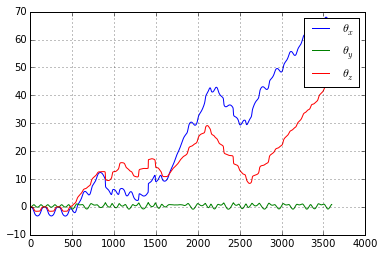

In [32]:
y = odeint(rhs, x0, t, args=({},))
plt.grid()
plt.plot(y[:,:3])
plt.legend(["$\\theta_x$", "$\\theta_y$", "$\\theta_z$"])


## Visualisation

In [33]:
i = 0
def update(*args):
    global i
    if i == len(y):
        i = 0
    box.Placement.Rotation = App.Rotation(*np.rad2deg(y[i][:3][::-1]))
    i += 1

In [34]:
timer = QtCore.QTimer()
timer.setInterval(200 * 1 / fps)
timer.timeout.connect(update)
timer.start()

In [35]:
timer.stop()
del(timer)
box.Placement.Rotation = App.Rotation(0, 0, 0)